In [1]:
import numpy as np
from scipy import linalg as la
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

In [2]:
FT_SIZE = 14;
plt.rc('font', size=FT_SIZE)
plt.rc('xtick',labelsize=FT_SIZE)
plt.rc('ytick',labelsize=FT_SIZE)

# MODEL: Hubbard-Mean-Field (NN & NNN) on 2D square lattice, periodic B.C., zero spin domain S_z = (nup-ndn)/2 = 0. 
# Assume up and down electrons behave the same way - no spin coupling Zeeman term
# Assume all numbers are real

In [3]:
def makeHpMatrix(Nx,Ny,t,tp,mu,density,sigma):
    '''Generate kinetic matrix for 2D square Nx-by-Ny lattice, periodic bdy conditions.
    Args:
        t = NN hopping strength
        tp = NNN hopping stength
        mu = Chemical potential
        Nx, Ny = Lattice dimensions
    Returns:
        A shape (N,N) float numpy array, N = Nx*Ny. '''

    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int)
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with periodic B.C.
            neighbors = [((x+1) % Nx,y),((x-1) % Nx,y),(x,(y+1) % Ny),(x,(y-1) % Ny)]
            next_neighbors = [((x+1) % Nx,(y+1) % Ny),((x-1) % Nx,(y+1) % Ny),
                              ((x+1) % Nx,(y-1) % Ny),((x-1) % Nx,(y-1) % Ny)]
            #get total indices of nearest neighbors
            for pt in neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-t)*np.ones(len(neighbors),dtype=float))
            #get total indices of next-nearest neighbors
            for pt in next_neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-tp)*np.ones(len(next_neighbors),dtype=float))
            #everything stays in n-th column
            j = np.append(j,n*np.ones(len(neighbors)+len(next_neighbors),dtype=int))
            
            #chemical potential contribes only to diagonal elements
            i = np.append(i,n);
            j = np.append(j,n);
            data = np.append(data,-mu + 0.5*U*(density[n]-sigma[n]))
    
    #Construction
    matrix = coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny))
    return matrix

In [4]:
def makeHmMatrix(Nx,Ny,t,tp,mu,density,sigma):
    '''Generate kinetic matrix for 2D square Nx-by-Ny lattice, periodic bdy conditions.
    Args:
        t = NN hopping strength
        tp = NNN hopping stength
        mu = Chemical potential
        Nx, Ny = Lattice dimensions
    Returns:
        A shape (N,N) float numpy array, N = Nx*Ny. '''

    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int)
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with periodic B.C.
            neighbors = [((x+1) % Nx,y),((x-1) % Nx,y),(x,(y+1) % Ny),(x,(y-1) % Ny)]
            next_neighbors = [((x+1) % Nx,(y+1) % Ny),((x-1) % Nx,(y+1) % Ny),
                              ((x+1) % Nx,(y-1) % Ny),((x-1) % Nx,(y-1) % Ny)]
            #get total indices of nearest neighbors
            for pt in neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-t)*np.ones(len(neighbors),dtype=float))
            #get total indices of next-nearest neighbors
            for pt in next_neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-tp)*np.ones(len(next_neighbors),dtype=float))
            #everything stays in n-th column
            j = np.append(j,n*np.ones(len(neighbors)+len(next_neighbors),dtype=int))
            
            #chemical potential contribes only to diagonal elements
            i = np.append(i,n);
            j = np.append(j,n);
            data = np.append(data,-mu + 0.5*U*(density[n]+sigma[n]))
    
    #Construction
    matrix = coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny))
    return matrix

In [5]:
def initDeltaMatrix(Nx,Ny,Vd):
    # Initialize vectors of row and column indices, matrix data
    i,j = np.empty(0,dtype=int), np.empty(0,dtype=int);
    data = np.empty(0,dtype=float);
    
    #Look at each lattice pt, find nearest neighbors
    for y in range(Ny):
        for x in range(Nx):
            #total index n
            n = x + Nx*y;
            #neighbors, with periodic B.C.
            neighbors = [((x+1) % Nx,y),((x-1) % Nx,y),(x,(y+1) % Ny),(x,(y-1) % Ny)]
            #get total indices of nearest neighbors
            for pt in neighbors: 
                i = np.append(i,pt[0]+ Nx*pt[1]);
            data = np.append(data,(-Vd)*np.ones(len(neighbors),dtype=float))
            #get total indices of next-nearest neighbors
            #everything stays in n-th column
            j = np.append(j,n*np.ones(len(neighbors),dtype=int))
    
    #Construction
    return coo_matrix((data, (i,j)),shape = (Nx*Ny,Nx*Ny)).toarray(),i,j

In [6]:
def Build_H(Delta,n,sigma):
    H = np.empty((2*N,2*N),dtype=float)
    #(0,0) block
    Hp = makeHpMatrix(Nx,Ny,t,tp,mu,n,sigma);
    #(1,1) block
    Hm = makeHmMatrix(Nx,Ny,t,tp,mu,n,sigma);
    
    #row1 = hstack((Hp,Delta));
    #row2 = hstack((Delta.conj(),-Hm.conj()))
    
    #H = vstack((row1,row2))
    
    #set blocks of total hamiltonian matrix
    H[:N,:N] = Hp.toarray()
    H[N:,N:] = -Hm.toarray().conj();
    H[:N,N:] = Delta;
    H[N:,:N] = Delta.conj()
    return H

In [7]:
def Fermi_Dist(E,beta):
    return 1/(1+np.exp(beta*E))

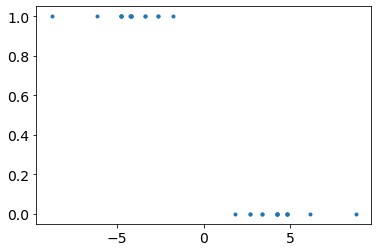

In [29]:
plt.plot(eigvals,Fermi_Dist(eigvals,beta),'.')

In [9]:
def Make_Delta_ij(Vd, E, Umat, Vmat, beta):
    '''Should we use this function to update delta?'''
    assert 2*N == E.shape[0] #use all energies
    assert Umat.shape == Vmat.shape == (N,2*N) #
    energy_term = np.tanh(0.5*beta*E)
    accum = np.zeros((N,N),dtype=float);
    for n in range(N):
        accum += (np.outer(Umat[:,n],Vmat[:,n])+\
                    np.outer(Vmat[:,n],Umat[:,n])) * energy_term[n] * Vd/4
    return accum

In [10]:
def Make_Nup(E,Umat):
    return np.sum((Umat**2) * Fermi_Dist(E,beta),axis=1)

In [11]:
def Make_Ndn(E,Vmat):
    return np.sum((Vmat**2) * (1-Fermi_Dist(E,beta)),axis=1)

In [291]:
t = 1 #NN hopping
tp = -0.4*t #NNN hopping
Vd = 1.34*t #attractive pairing interaction strength
Nx = 8; #lattice size
Ny = 16;
N = Nx*Ny; #total number of lattice sites
filling = 7/8 #hole doped
U = 8; #onsite repulsion
mu = 0.5*U*filling; #chemical potential
beta = 10;

In [292]:
#initialize parameters
sigma = np.zeros(N,dtype=float)
n = np.zeros(N,dtype=float) 
for x in range(Nx):
    for y in range(Ny):
        #total index n
        ntotal = x + Nx*y;
        n[ntotal] = filling
        sigma[ntotal] = 0.1*np.cos(np.pi*y/8)*(-1)**(x+y)


Delta,ilist,jlist = initDeltaMatrix(Nx,Ny,Vd)
H = Build_H(Delta,n,sigma) 

#note sure how to handle delta matrix
#plt.figure();
#plt.imshow(Delta);
#plt.title('init Delta matrix');plt.colorbar()

print(f'init <n> = {n}')
print(f'init <sigma> = {sigma}')
#plt.figure();

#Hamiltonian
#plt.figure();
#plt.imshow(H);plt.colorbar()
#plt.title("Init Hamiltonian")
#eigvals,eigvecs = la.eigh(H)
#plt.figure();
#plt.imshow(eigvecs)
#plt.colorbar();
#plt.title('init eigenvectors')

init <n> = [0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875
 0.875 0.875 0.875 0.875 0.875 0.875 0.875 0.875]
init <sigma> = [ 1.00000000e-01 -1.00000000e-01  1.00000000e-01 -1.00000000e-01
  1.00000000e-01 -1.00000000e-01  1.00000000e-01 -1.00000000e-01
 -9.23879533e-02  9.23879533e-02 -9.23879533e-02  9.23879533e-02

In [293]:
maxiter = 40
nit = 0;
while nit < maxiter:
    eigvals,eigvecs = la.eigh(H)
    #Take positive eigenvals and corresponding eigenvecs
    Umat = eigvecs[:N,:] #first N rows
    Vmat = eigvecs[N:,:] #last N rows
    #plt.figure();
    #plt.imshow(eigvecs)
    
    n_up = Make_Nup(eigvals,Umat);
    n_dn = Make_Ndn(eigvals,Vmat);
    n_new = n_up + n_dn;
    print('energy[0]',eigvals[0],'nup[0]',n_up[0],'ndn[0]',n_dn[0])
    sigma_new = n_up - n_dn; 
    Delta_new = Make_Delta_ij(Vd,eigvals,Umat,Vmat,beta);
    #Delta_new = np.zeros((N,N),dtype=float)
    #Delta_new[ilist,jlist] = Delta_full[ilist,jlist]
    
    change = la.norm(n_new-n),la.norm(sigma_new-sigma)
    print(np.mean(n_new-n))
    
    if np.max(change) < 1e-3:
        break
    else:
        Delta = Delta_new
        n = n_new;
        sigma = sigma_new
        H = Build_H(Delta,n,sigma) 
    
    nit +=1


if nit >= maxiter:
    print('no convergence')
else:
    print(f'converged after {nit} iterations')
#plt.figure();
#plt.imshow(Delta);
#plt.title('Delta matrix');plt.colorbar()

print(f'<n> = {np.mean(n)}')
print(f'<sigma> = {sigma}')

#Hamiltonian
H = Build_H(Delta,n,sigma) 
#plt.figure();
#plt.imshow(H);plt.colorbar()
#plt.title("Hamiltonian")

#Diagonalize
#eigvals,eigvecs = la.eigh(H)
#print(f"energies: {eigvals}")

#plt.figure();
#plt.imshow(eigvecs);plt.colorbar()
#plt.title('eigenvectors')


energy[0] -7.758861637596997 nup[0] 0.6556860523977461 ndn[0] 0.5283381346866559
0.3128820673081041
energy[0] -6.871687386696335 nup[0] 0.5732385617045559 ndn[0] 0.2573996639716098
-0.3901034927013528
energy[0] -5.421828725923662 nup[0] 0.8342649749040983 ndn[0] 0.2743946780655767
0.43778155520411877
energy[0] -7.3533505602744285 nup[0] 0.9021149722884996 ndn[0] 0.10199513623194119
-0.4149322097671171
energy[0] -6.815010618885083 nup[0] 0.93646446305145 ndn[0] 0.062408510013168085
0.30438139581617374
energy[0] -7.699922359012986 nup[0] 0.9445974351011268 ndn[0] 0.055293435364490245
-0.25000926871412105
energy[0] -7.246940346217614 nup[0] 0.9460511064323959 ndn[0] 0.0539416585821128
0.24999991520490122
energy[0] -8.153598208489626 nup[0] 0.9463119253835297 ndn[0] 0.053688549560282135
-0.24999996233840044
energy[0] -7.284172478448735 nup[0] 0.9463615816229145 ndn[0] 0.0536410165282966
0.24999997777610966
energy[0] -8.178157397409198 nup[0] 0.9463698542570054 ndn[0] 0.05362945470565859
-0

-8.178929465529063


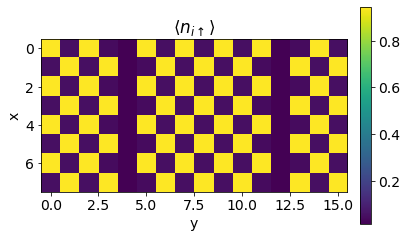

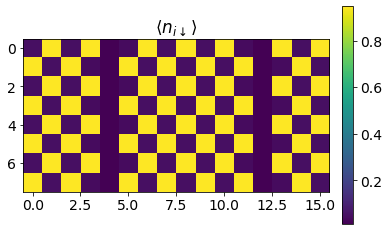

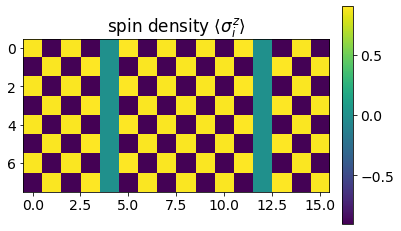

In [294]:
up_occ = np.zeros((Nx,Ny),dtype=float)
down_occ = np.zeros((Nx,Ny),dtype=float)
sigma_2d = np.zeros((Nx,Ny),dtype=float)
print(eigvals[0])

for ntotal in range(N):
    x = ntotal % Nx;
    y = ntotal // Nx;
    up_occ[x,y] = n_up[ntotal]
    down_occ[x,y] = n_dn[ntotal]
    sigma_2d[x,y] = sigma_new[ntotal]

plt.figure();plt.imshow(up_occ);
plt.colorbar(fraction=0.046, pad=0.04);
plt.title(r'$\langle n_{i\uparrow}\rangle$')
plt.xlabel('y')
plt.ylabel('x')
plt.figure();plt.imshow(down_occ);
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r'$\langle n_{i\downarrow}\rangle$')
plt.figure();plt.imshow(sigma_2d);
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r'spin density $\langle \sigma_i^z\rangle$');

the iteration procedure seems to be indifferent w.r.t. particle/hole symmetry, but the energy shows that 7/8 filling is more energetically favorable